# Practice 1: Montecarlo Simulation

@roman avj

21 sep 2023

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Part 0: Settings

In [2]:
# implicit function
def F(x, y):
    return (x**2 + y - 10)**2 + (x + y**2 - 12)**2 - 100

In [ ]:
10**(1/4)

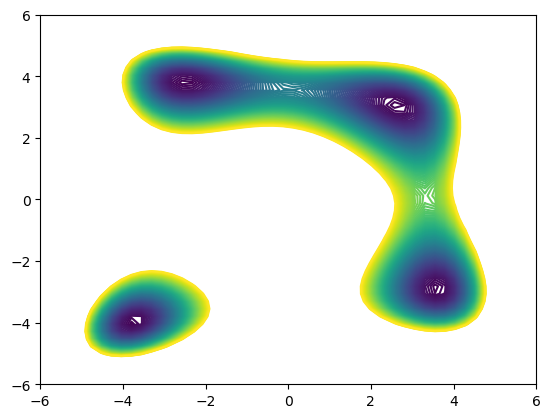

In [15]:
# plot level curves
def plot_level_curve(f, x_range, y_range, levels):
    x = np.linspace(*x_range)
    y = np.linspace(*y_range)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    plt.contour(X, Y, Z, levels=levels)

# plot level curves
x_range = (-6, 6)
y_range = (-6, 6)
levels = np.arange(-100, 1, 1)
plot_level_curve(F, x_range, y_range, levels)

# Part 1: Estimate the area of $\mathcal{G}: F(x, y) \leq 0$ 


Total area: 144 
 Region area: 40.895999999999994


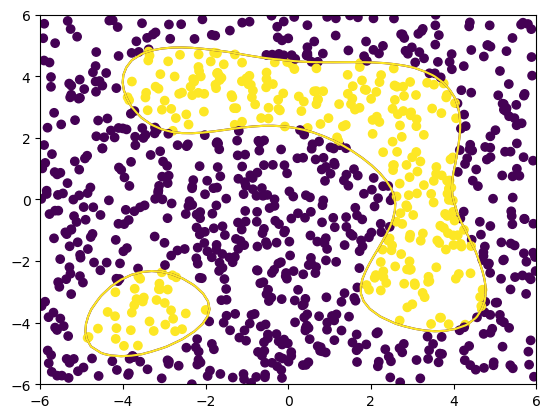

In [122]:
# estimate the area of F(x, y) <= 0 using montecarlo method

## Step 1: generate random points
# set random number generator
rng = np.random.default_rng(seed=8)
N = 1000
lp_range = (-6, 6)
xy_range = rng.uniform(*x_range, (N, 2))

## Step 2: estimate the area
# area of the square
total_area = (lp_range[1] - lp_range[0])**2

# area of the region
region_percentage = np.mean(F(xy_range[:, 0], xy_range[:, 1]) <= 0)

### Step 3: estimate the area
area = total_area * region_percentage
print(f"Total area: {total_area} \n Region area: {area}")

### Step 4: plot the points
# plot level curves
# plot_level_curve(F, x_range, y_range, levels=np.array([0]))
# plot points, color points in the region
plot_level_curve(F, x_range, y_range, levels=np.array([0, 0.1]))
plt.scatter(xy_range[:, 0], xy_range[:, 1], c=F(xy_range[:, 0], xy_range[:, 1]) <= 0)
plt.show()


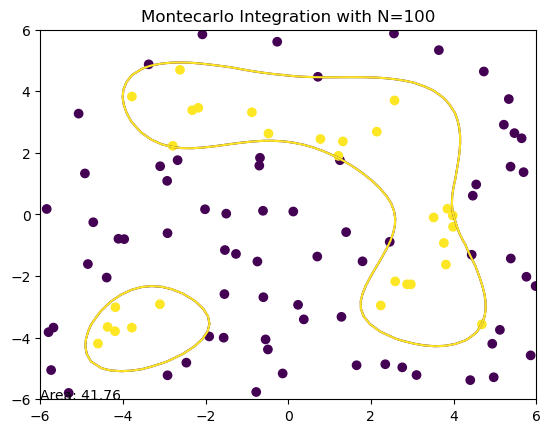

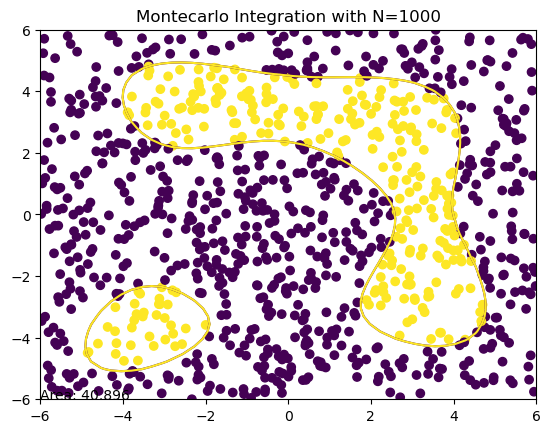

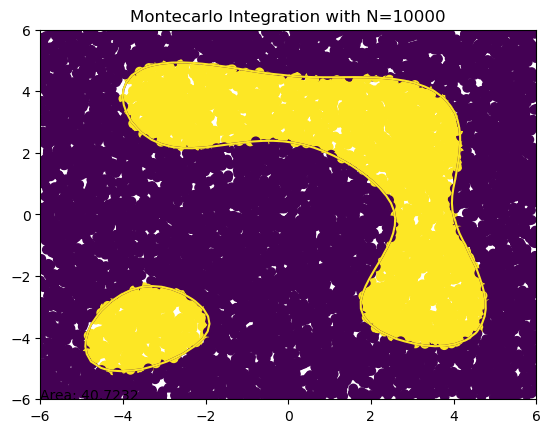

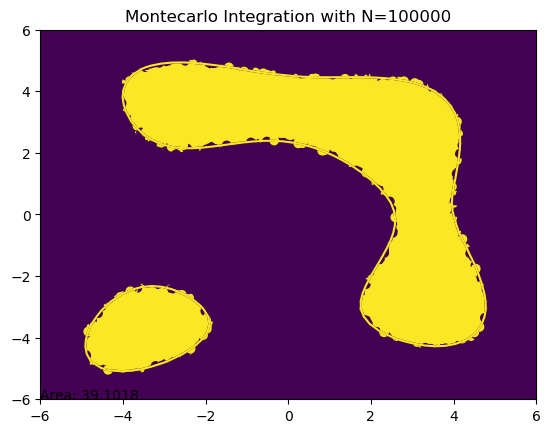

In [123]:
# pass to function
def montecarlo_integration(f, lp_range, N, seed=8, verbose=False):
    # fix random number generator
    rng = np.random.default_rng(seed=8)
    # generate random points
    xy_range = rng.uniform(*lp_range, (N, 2))
    # estimate the area
    total_area = (lp_range[1] - lp_range[0])**2
    region_percentage = np.mean(f(xy_range[:, 0], xy_range[:, 1]) <= 0)
    area = total_area * region_percentage
    # plot the points
    if verbose:
        plot_level_curve(f, lp_range, lp_range, levels=np.array([0, 0.1]))
        plt.scatter(xy_range[:, 0], xy_range[:, 1], c=f(xy_range[:, 0], xy_range[:, 1]) <= 0)
        # add title
        plt.title(f"Montecarlo Integration with N={N}")
        # add annotation bottom left
        plt.annotate(f"Area: {np.round(area, 4)}", xy=(lp_range[0], lp_range[0]), xycoords="data")
        plt.show()
    return area

# test the function for 10^2, 10^2, ..., 10^8 points
N = np.logspace(2, 8, 7, dtype=int)
areas = [montecarlo_integration(F, x_range, n, verbose=(n<=1e+5)) for n in N]


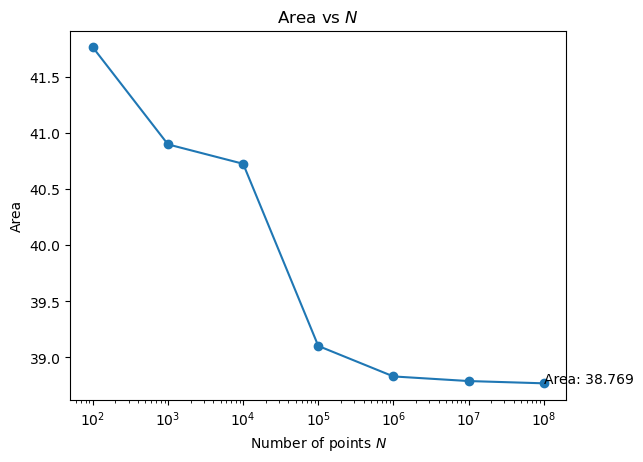

In [124]:
# plot the areas vs N with x log scale as bar plot
plt.plot(N, areas)
plt.scatter(N, areas)
# add value of the area
plt.annotate(f"Area: {np.round(areas[-1], 4)}", xy=(N[-1], areas[-1]), xycoords="data")
plt.xscale("log")
plt.xlabel("Number of points $N$")
plt.ylabel("Area")
plt.title("Area vs $N$")
plt.show()

# Part 2: Recursive estimation

In [141]:
# my way
def grid_division(lp_range, h=2):
    # generate grids for a given range
    x_min, x_max, y_min, y_max = lp_range
    x_step = (x_max - x_min) / h
    y_step = (y_max - y_min) / h
    grids = []
    for i in range(h):
        for j in range(h):
            x1 = x_min + i * x_step
            x2 = x_min + (i + 1) * x_step
            y1 = y_min + j * y_step
            y2 = y_min + (j + 1) * y_step
            grids.append((x1, x2, y1, y2))
    return grids

def check_sign_pos(signs):
    # check if all points are positive
    list_signs = [sign > 0 for sign in signs]
    # print(list_signs)
    # print(all(list_signs))
    return all(list_signs)

def check_sign_neg(signs):
    # check if all points are negative
    list_signs = [sign <= 0 for sign in signs]
    # print(all(list_signs))
    return all(list_signs)

def integrate_grid(list_sign, grid):
    if check_sign_pos(list_sign):
        return 0.0
    else:
        # unpack
        x1, x2, y1, y2 = grid
        # integrate
        return (x2 - x1) * (y2 - y1)

def unpack_grid(grid):
    x1, x2, y1, y2 = grid
    return [(x1, y1), (x1, y2), (x2, y1), (x2, y2)]

def integrate_recursive_armonic(F, grids, depth):
    global grid_extended

    # finished recursion
    if len(grids) == 0:
        return 0.0    

    # max recursion
    if depth == 0:
        area = 0.0
        for grid in grids:
            points = unpack_grid(grid)
            list_sign = [np.sign(F(x, y)) for x, y in points]
            area += integrate_grid(list_sign, grid)
        return area
    
    # recursive
    grid = grids.pop()
    # get points
    points = unpack_grid(grid)
    # check sign of points
    list_sign = [np.sign(F(x, y)) for x, y in points]
    # integrate
    if check_sign_pos(list_sign) or check_sign_neg(list_sign):
        return integrate_grid(list_sign, grid) + integrate_recursive_armonic(F, grids, depth)
    else:
        new_grids = grid_division(grid, h=2)
        # save to grid extended
        grid_extended.extend(new_grids)
        return integrate_recursive_armonic(F, new_grids, depth-1) + integrate_recursive_armonic(F, grids, depth)


In [145]:
# main #
# get grid division
lp_range = (-6, 6, -6, 6)
grids = grid_division(lp_range, h=10)
grid_extended = grids.copy()
# integrate
area = integrate_recursive_armonic(F, grids, depth=4)
print(f"Area: {area}")

Area: 40.48312499999999


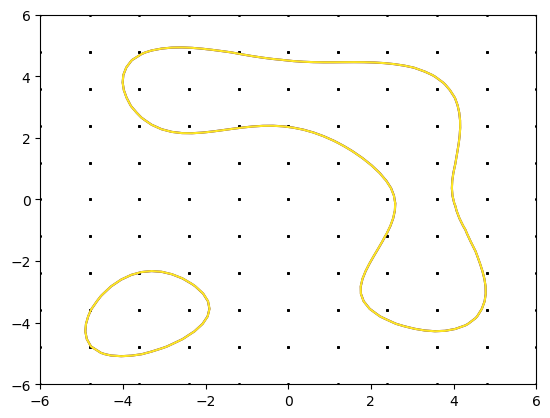

In [146]:
# plot grids
grids = grid_division(lp_range, h=10)
plot_level_curve(F, x_range, y_range, levels=np.array([0, 0.1]))
# plot points in the grid
for grid in grids:
    x1, x2, y1, y2 = grid
    plt.scatter([x1, x1, x2, x2], [y1, y2, y1, y2], c="black", s=1)
plt.show()


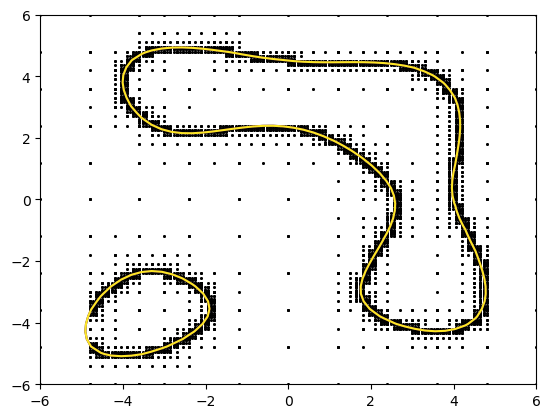

In [147]:
plot_level_curve(F, x_range, y_range, levels=np.array([0, 0.1]))
# plot points in the grid
for grid in grid_extended:
    x1, x2, y1, y2 = grid
    plt.scatter([x1, x1, x2, x2], [y1, y2, y1, y2], c="black", s=1)
plt.show()

# Part 3: Probabillities over $\mathcal{G}$

## Part 3.0) setup

In [ ]:
# set random numbers
rng = np.random.default_rng(seed=8)
N = 1000
# (x, y) \in R are multinormal distributed  with mean (\mu, \mu) from -5 to 5
# and cov [[2, 0], [0, 2]]
# generate dictionary for random variables
mus = np.arange(5, -6, -1)
sigma = np.eye(2) * 2

# Create an empty dictionary to store the random variables
dict_rnd_multinormal = {}

# Generate random variables and store them in the dictionary
for mu in mus:
    x_y_samples = np.random.multivariate_normal(mean=np.array([-mu, mu]), cov=sigma, size=N)
    dict_rnd_multinormal[f"x_{mu}"] = {
        "x": x_y_samples,
        "mu": np.array([-mu, mu]),
        "sigma": sigma
    }

In [ ]:
# plot curves for each mu
for mu in mus:
    # plt scatters
    plt.scatter(dict_rnd_multinormal[f"x_{mu}"]["x"][:, 0], dict_rnd_multinormal[f"x_{mu}"]["x"][:, 1], label=f"$\mu={mu}$")
    # plot level curves
    plot_level_curve(F, x_range, y_range, levels=np.array([0, 0.1]))
    # axis limits
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.legend()
    plt.show()

## Part 3.a) Formulate the integral to calculate the probability

In [ ]:
# WIP

# Part 3.c) Estimate the area of the region using montecarlo integration

In [ ]:
# get multivariate normal distribution using scipy
def multinorm_dist(x, mu, sigma):
    return multivariate_normal.pdf(x, mean=mu, cov=sigma)

In [ ]:
# set values
mus0 = dict_rnd_multinormal[f"x_0"]
mus0


In [ ]:
# use montecarlo integration to estimate the area
def montecarlo_integration_binormal(f, points, mu, sigma, lp_range=None, verbose=False):
    # evaluate points that are in the region
    prop = f(points[:, 0], points[:, 1]) <= 0
    # estimate the area
    area = np.mean(prop) 
    # plot the points
    if verbose:
        plot_level_curve(f, lp_range, lp_range, levels=np.array([0, 0.1]))
        plt.scatter(
            points[:, 0], points[:, 1], 
            c=prop
            )
        # add title
        plt.title(f" N={points.shape[0]}, mu = {mu}")
        # add annotation bottom left
        plt.annotate(f"Proba: {100 * np.round(area, 2)}%", xy=(lp_range[0], lp_range[0]), xycoords="data")
        plt.xlim(-10, 10)
        plt.ylim(-10, 10)
        plt.show()

    return area
for mus in dict_rnd_multinormal.values():
    areas = montecarlo_integration_binormal(F, mus["x"], mus["mu"], mus["sigma"], x_range, verbose=True)


## N from 10^2 to 10^8 and mu from -5 to 5 

In [ ]:
def estimate_probas(N, mus, sigma, seed=8):
    # set random numbers
    rng = np.random.default_rng(seed=seed)

    # for each n in N generate random variables
    dict_possibilities = {}
    for n in N:
        print(f"Generating for N={n}")
        # for each mu in mus
        dict_rnd_multinormal = {}
        for mu in mus:
            x_y_samples = np.random.multivariate_normal(
                mean=np.array([-mu, mu]), cov=sigma, size=n
                )
            dict_rnd_multinormal[f"x_{mu}"] = {
                "x": x_y_samples,
                "mu": np.array([-mu, mu]),
                "sigma": sigma
            }
        dict_possibilities[f"N_{n}"] = dict_rnd_multinormal

    # estimate the probabilities for each n and mu
    dict_probas = {}
    for n in N:
        print(f"Estimating for N={n}")
        dict_probas[f"N_{n}"] = {}
        for mu in mus:
            dict_probas[f"N_{n}"][f"mu_{mu}"] = montecarlo_integration_binormal(
                f=F, 
                points=dict_possibilities[f"N_{n}"][f"x_{mu}"]["x"], 
                mu=dict_possibilities[f"N_{n}"][f"x_{mu}"]["mu"], 
                sigma=dict_possibilities[f"N_{n}"][f"x_{mu}"]["sigma"]
                )
            
    # pass it to a dataframe
    # Iterate through the dictionary and extract the values
    data = []
    for N, inner_dict in dict_probas.items():
        for mu, proba in inner_dict.items():
            n_value = int(N.split('_')[1])  # Extract the N value
            mu_value = int(mu.split('_')[1])  # Extract the Mu value
            data.append([mu_value, n_value, proba])
    df = pd.DataFrame(data, columns=['mean', 'size', 'probs'])
    df = df.sort_values(by=['mean', 'size'], ignore_index=True)

    return df

# estimate probabilities
N = np.logspace(2, 8, 7, dtype=int)
mus = np.arange(5, -6, -1)
sigma = np.eye(2) * 2
df_probas = estimate_probas(N, mus, sigma, seed=8)


In [ ]:
df_probas

In [ ]:
# generate a bar plot for each mu with N
df_plot = df_probas.copy()
df_plot["size"] = df_plot["size"].astype(str)

# plot
for group, gdf in df_plot.groupby("mean"):
    # plot bar plot
    plt.bar(gdf["size"], gdf["probs"], label=f"$\mu={group}$")
    # add value, add 4 decimals
    for i, v in enumerate(gdf["probs"]):
        plt.text(i, v, f"{np.round(100*v, 4)}%", ha="center", va="bottom")
    # y axis as percents
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}%".format(int(x*100))))
    # y axis limit
    plt.ylim(0, 1)
    # add title
    plt.title(f"Probas for $\mu={group}$")
    # add legend bottom right
    plt.legend(loc="lower right")
    plt.show()
    